In [1]:
import numpy as np
#import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video
from IPython.display import Audio

In [5]:
def get_interpolated(array, index):
    if not hasattr(array, "__len__"): return array # if scalar
    return (1 - (index[0] % 1)) * get_interpolated(array[int(np.floor(index[0]))], index[1:]) + (index[0] % 1) * get_interpolated(array[int(np.ceil(index[0]))], index[1:])

In [6]:
def calculate_next_psi(psi, dt, potential):
    n = psi.shape[0]
    next_psi = np.zeros((n, n), dtype=np.complex_)
    
    # potential-part
    next_psi = [[psi[i, j] * np.exp(-1j * dt * potential[i, j]) for j in range(n)] for i in range(n)]

    next_psi = np.fft.fft2(next_psi)
    
    for i in range(n):
        for j in range(n):
            k = 2*np.pi * min(i, n-i)
            l = 2*np.pi * min(j, n-j)
            theta = (k*k + l*l) * dt
            next_psi[i, j] *= np.exp(1j * theta)
    
    next_psi = np.fft.ifft2(next_psi)
    return next_psi

In [7]:
def gaussian(x, y, n, offset, width):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return np.exp(-(x*x + y*y) / (width*width)) + 0j

In [8]:
def parabolar(x, y, n, offset, factor):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return factor * (x*x + y*y) + 0j
    

In [9]:
parabolar(64, 0, 128, [0, 0], 1)

(1+0j)

In [10]:
def circle(rad, radius, offset, n):
    return (radius * np.array([np.cos(rad), np.sin(rad)]) + offset) * n//2 + n//2

In [11]:
np.concatenate(([5], circle(0, 1, 0, 128)), axis=0)

array([  5., 128.,  64.])

In [12]:
n = 128
fps = 12
duration = 5

samplerate = 44100
frequency = 110
interest_radius = 0.5
interest_center = [0, 0]

frames = [] # for storing the generated images
#fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#video = cv2.VideoWriter('test.mp4', fourcc, fps, (800, 600))

psi = np.array([[gaussian(x, y, n, offset=[-0.5, 0.0], width=0.2) for x in range(n)] for y in range(n)])
potential = np.array([[parabolar(x, y, n, offset=[0,0], factor=100) for x in range(n)] for y in range(n)])
frames.append(psi)

In [13]:
for i in range(fps*duration):
    for timestep in range(1):
        psi = calculate_next_psi(psi, 0.0005, potential)
    frames.append(psi)

print("Finished simulation")

Finished simulation


In [0]:
#plt.pcolormesh(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1)
plt.pcolormesh(np.abs(potential))
plt.colorbar()
plt.show()

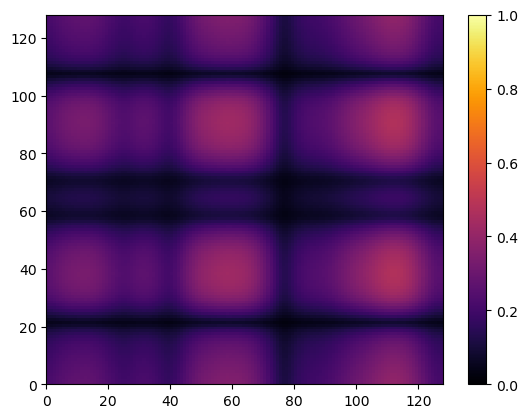

In [49]:
# FuncAnimation
fig, ax = plt.subplots()
cax = ax.pcolormesh(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1)
fig.colorbar(cax)

def animate(i):
    cax.set_array(pow(np.abs(frames[i]), 2.0/3.0).flatten())

anim = animation.FuncAnimation(fig, animate, frames=len(frames))
anim.save('visual.mp4', fps=fps, dpi=150, bitrate=4000)
plt.show()

In [50]:
# Sonification
rad_per_sample = 2 * np.pi * frequency / samplerate
audio = [np.square(np.abs(get_interpolated(frames, np.concatenate((np.array([i * fps/samplerate]), circle(rad_per_sample * i, interest_radius, interest_center, n)), axis=0)))) for i in range(samplerate*duration)]

print("Finished sonicifaction")

Finished sonicifaction


In [63]:
Audio(audio, rate=samplerate)